In [10]:
# Copyright 2021 Multiscale Modeling of Fluid Materials, TU Munich
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [11]:
!pip install matplotlib

In [12]:
import numpy as onp

import jax
import jax.numpy as jnp

from jax import random, vmap

import matplotlib.pyplot as plt

from jax.scipy.stats import norm
from jax.scipy.stats import uniform

from numpyro import sample as npy_smpl
import numpyro.infer as npy_inf
import numpyro.distributions as npy_dist

from scipy.stats import gaussian_kde

from functools import partial

from jax_sgmc import adaption
from jax_sgmc import potential
from jax_sgmc import data
from jax_sgmc import scheduler
from jax_sgmc import integrator
from jax_sgmc import solver

Linear Regression
=========================

This is a toy example with artificial reference data.

Problem
---------

$$ y_i \sim \mathcal{N}\left(\sum_{j=1}^N w_jx_i, \sigma^2\right),\ i = 1, \ldots, 4$$

Reference Data
---------------

$$ u_{1, i}, u_{2, i}, u_{3,i}, u_{4, i} \sim \mathcal{U}\left(-1, 1 \right)$$

The independent variables are uniformly distributed and the first two and last
two pairs are correlated.

$$ x_i = \left(\begin{array}{c} u_{i,1} + u_{2,i} \\ u_{2,i} \\ 0.1u_{3,i} -0.5u_{4,i} \\ u_{4,i} \end{array} \right)$$

The correct solution $w$ is uniformly distributed

$$ \boldsymbol{w} \sim \mathcal{U}\left(-1, 1\right) $$

In [13]:
N = 4
samples = 1000 # Total samples
sigma = 0.5

key = random.PRNGKey(0)
split1, split2, split3 = random.split(key, 3)

w = random.uniform(split3, minval=-1, maxval=1, shape=(N, 1))
noise = jnp.sqrt(sigma) * random.normal(split2, shape=(samples, 1))
x = random.uniform(split1, minval=-10, maxval=10, shape=(samples, N))
x = jnp.stack([x[:, 0] + x[:, 1], x[:, 1], 0.1 * x[:, 2] - 0.5 * x[:, 3],
               x[:, 3]]).transpose()
y = jnp.matmul(x, w) + noise


Solution with numpyro
=======================

In [14]:
def numpyro_model(y_obs=None):
  sigma = npy_smpl("sigma", npy_dist.Uniform(low=0.0, high=10.0))
  weights = npy_smpl("weights",
                     npy_dist.Uniform(low=-10 * jnp.ones((N, 1)),
                                      high=10 * jnp.ones((N, 1))))

  y_pred = jnp.matmul(x, weights)
  npy_smpl("likelihood", npy_dist.Normal(loc=y_pred, scale=sigma), obs=y_obs)

# Collect 1000 samples

kernel = npy_inf.HMC(numpyro_model)
mcmc = npy_inf.MCMC(kernel, 1000, 1000, progress_bar=False)
mcmc.run(random.PRNGKey(0), y_obs=y)
mcmc.print_summary()

w_npy = mcmc.get_samples()["weights"]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       sigma      0.71      0.02      0.70      0.68      0.73   2554.86      1.00
weights[0,0]      0.10      0.00      0.10      0.09      0.10    501.27      1.00
weights[1,0]     -0.49      0.01     -0.49     -0.50     -0.48   1720.10      1.00
weights[2,0]     -0.17      0.04     -0.17     -0.23     -0.10   1091.12      1.00
weights[3,0]     -0.64      0.02     -0.64     -0.67     -0.61    872.58      1.00

Number of divergences: 0


Solution with Jax SGMC
========================

Reference Data
---------------

The reference data and the desired batch shape must be load into a data loader.
We set the mini-batch for the stochastic gradient evaluation to $M = 10$ and the
cached batch count to $cs = 1000$.

In [15]:
M = 10
cs = 1000

data_loader = data.NumpyDataLoader(M, x=x, y=y)
batch_fn = data.random_reference_data(data_loader, cached_batches_count=cs)

Model
-----

Next we have to setup the model and the potential function with a evaluation
strategy. Because the model is not very complex, the evaluation of the potential
for a minibatch of data can be vectorized.

In [16]:
def model(sample, observations):
    weights = sample["w"]
    predictors = observations["x"]
    return jnp.dot(predictors, weights)

def likelihood(sample, observations):
    sigma = sample["sigma"]
    y = observations["y"]
    y_pred = model(sample, observations)
    return norm.logpdf(y - y_pred, scale=sigma)

def prior(sample):
    return 0.0

# If the model is more complex, the strategy can be set to map for sequential
# evaluation and pmap for parallel evaluation.
potential_fn = potential.minibatch_potential(prior=prior,
                                             likelihood=likelihood,
                                             strategy="vmap")

Solver
-------

In addition to the refernce data and the potential function, the solver requires
a schedule determining parameters such as the step size and the temperature.
Moreover, an adaption strategy can be provided for some solvers to perform
stochastic gradient langevin diffusion on a manifold.

Next we set up default Stochastic Gradient Langevin Diffusion (SGLD) and SGLD
using RMSprop-adaption.

In [17]:
# Number of iterations
iterations = 50000

# Adaption strategy
rms_prop = adaption.rms_prop()

# Integrators
default_integrator = integrator.langevin_diffusion(potential_fn,
                                                   batch_fn)
rms_integrator = integrator.langevin_diffusion(potential_fn,
                                               batch_fn,
                                               rms_prop)

# Initial value for starting
sample = {"w": jnp.zeros((N, 1)), "sigma": jnp.array(10.0)}

# Schedulers
default_step_size = scheduler.polynomial_step_size_first_last(first=0.001,
                                                              last=0.000005)
rms_step_size = scheduler.polynomial_step_size_first_last(first=0.05,
                                                          last=0.001)
burn_in = scheduler.initial_burn_in(20000)
rms_random_thinning = scheduler.random_thinning(rms_step_size,
                                                burn_in,
                                                4000)
default_random_thinning = scheduler.random_thinning(default_step_size,
                                                    burn_in,
                                                    4000)

default_scheduler = scheduler.init_scheduler(step_size=default_step_size,
                                             burn_in=burn_in,
                                             thinning=default_random_thinning)
rms_scheduler = scheduler.init_scheduler(step_size=rms_step_size,
                                         burn_in=burn_in,
                                         thinning=rms_random_thinning)

default_sgld = solver.sgmc(default_integrator)
rms_sgld = solver.sgmc(rms_integrator)

default_run = solver.mcmc(default_sgld, default_scheduler)
rms_run = solver.mcmc(rms_sgld, rms_scheduler)

default = default_run(default_integrator[0](sample), iterations=iterations)
rms = rms_run(rms_integrator[0](sample), iterations=iterations)

Results
=========

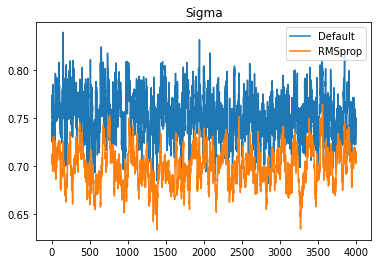

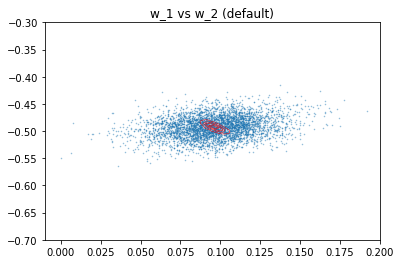

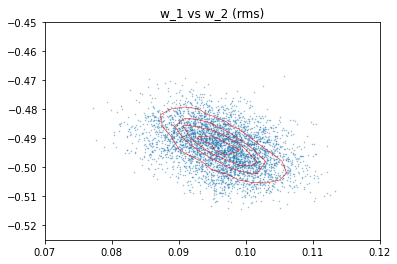

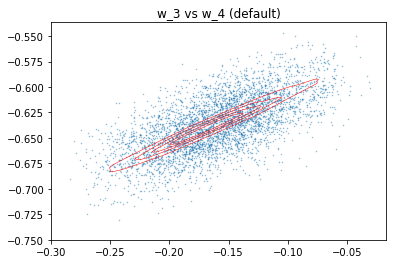

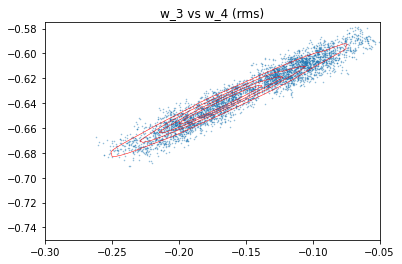

In [18]:
plt.figure()
plt.title("Sigma")

plt.plot(default["sigma"], label="Default")
plt.plot(rms["sigma"], label="RMSprop")

plt.legend()

# Now, only take the last 4000 steps

w_default = default["w"][-4000:, :]
w_rms = rms["w"][-4000:, :]

# Contours of numpyro solution

levels = onp.linspace(0.1, 1.0, 5)

# w1 vs w2
w12 = gaussian_kde(jnp.squeeze(w_npy[:, 0:2].transpose()))
w1d = onp.linspace(0.00, 0.20, 100)
w2d = onp.linspace(-0.70, -0.30, 100)
W1d, W2d = onp.meshgrid(w1d, w2d)
p12d = onp.vstack([W1d.ravel(), W2d.ravel()])
Z12d = onp.reshape(w12(p12d).T, W1d.shape)
Z12d /= Z12d.max()

# Default

plt.figure()
plt.title("w_1 vs w_2 (default)")

plt.contour(W1d, W2d, Z12d, levels, colors='red', linewidths=0.5)
plt.plot(w_default[:, 0], w_default[:, 1], 'o', alpha=0.5, markersize=0.5,
         zorder=-1)

# rm


plt.figure()
plt.title("w_1 vs w_2 (rms)")

plt.xlim([0.07, 0.12])
plt.ylim([-0.525, -0.450])
plt.contour(W1d, W2d, Z12d, levels, colors='red', linewidths=0.5)
plt.plot(w_rms[:, 0], w_rms[:, 1], 'o', alpha=0.5, markersize=0.5, zorder=-1)

# w3 vs w4

w34 = gaussian_kde(jnp.squeeze(w_npy[:, 2:4].transpose()))
w3d = onp.linspace(-0.3, -0.05, 100)
w4d = onp.linspace(-0.75, -0.575, 100)
W3d, W4d = onp.meshgrid(w3d, w4d)
p34d = onp.vstack([W3d.ravel(), W4d.ravel()])
Z34d = onp.reshape(w34(p34d).T, W3d.shape)
Z34d /= Z34d.max()

# Default

plt.figure()

plt.title("w_3 vs w_4 (default)")

plt.contour(W3d, W4d, Z34d, levels, colors='red', linewidths=0.5)
plt.plot(w_default[:, 2], w_default[:, 3], 'o', alpha=0.5, markersize=0.5,
         zorder=-1)

# rm


plt.figure()
plt.title("w_3 vs w_4 (rms)")
plt.contour(W3d, W4d, Z34d, levels, colors='red', linewidths=0.5)
plt.plot(w_rms[:, 2], w_rms[:, 3], 'o', alpha=0.5, markersize=0.5, zorder=-1)